<a href="https://colab.research.google.com/github/tqiaowen/LSTrAP-Cloud/blob/master/mod_neighbourhood_and_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Generating Neighbourhood and Network Files
This script is based on the original download script found [here](https://github.com/wirriamm/CoNeGC/blob/master/2_Generating_neighbourhood_and_network_files_30Jan.ipynb), obtained on 03 February 2020.

### What does this script do?
This script will help you perform quality control of the RNA-seq data downloaded by the previous script and generate the files necessary to visualise the co-expression network on this page and also offline on [Cytoscape Desktop](https://cytoscape.org/download.html).

### What you will require
1. A folder to save the outputs from this script
2. Folder created from the previous download script containing the kallisto outputs, download report 
3. Mercator output (for plants) or file in the mercator output format ([example](https://github.com/tqiaowen/LSTrAP-Cloud/blob/master/examples/mercator_non-plant.txt)) for non-plant organims.<br>NOTE: Gene IDENTIFIERS should be in **lowercase**. File provided should be a **tab-delimited** text file (i.e. '.txt').

### Expected outputs
1. Neighbourhood file<br>
   contains information about the neighbourhood of the gene of interest such as geneID, PCC value and descriptions from mercator
2. Network file<br>
   contains information between gene pairs and their corresponding PCC values
3. HTML file<br>
   This file can be open standalone in a brower (tested on Chrome) and is the same file used to display the network in this notebook.<br>
   **TIP**: Options to download the default network as png and JSON formats are available. The JSON network can be further modified in [Cytoscape Desktop](https://cytoscape.org/download.html).

### Bonus tips?
1. Location of files saved is in your specified output folder. In addition, we have also printed the location after the files are created. Look out for them after you have ran the cells!
2. Want to look at another gene with the same TPM file? **Avoid re-compiling the TPM file** by doing the following steps!<br>
  2.1 Edit the description of gene to be analysed in step 2.2 Input form<br>
  2.2 Run step 2.2<br>
  2.3 Skip to step 2.9 and continue with your analysis!<br>
3. If you encoutner any issues, please raise an issue on [Github](https://github.com/tqiaowen/LSTrAP-Cloud) or contact us [here](mailto:qiaowen001@e.ntu.edu.sg).

In [18]:
#@markdown 2.1 Mount Google Drive and import python modules

#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!rm -rf /content/sample_data
!wget https://raw.githubusercontent.com/tqiaowen/LSTrAP-Cloud/master/Dependencies/MapmanBin_colorsc.txt

#Import modules
import os
import time
from datetime import datetime as dt
import scipy.stats as stats
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, HTML
from google.colab import widgets #https://colab.research.google.com/notebooks/widgets.ipynb

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
--2020-02-13 03:59:32--  https://raw.githubusercontent.com/tqiaowen/LSTrAP-Cloud/master/Dependencies/MapmanBin_colorsc.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1217 (1.2K) [text/plain]
Saving to: ‘MapmanBin_colorsc.txt’

MapmanBin_colorsc.t 100%[===================>]   1.19K  --.-KB/s    in 0s      

2020-02-13 03:59:32 (102 MB/s) - ‘MapmanBin_colorsc.txt’ saved [1217/1217]



####User input of variables

In [0]:
#@title 2.2 Input form {display-mode: "form"}
#@markdown Please use absolute paths for the files. Tip: After mounting your Google Drive, right click on the file and copy path.<br>
#@markdown <html><div><img src="https://github.com/tqiaowen/LSTrAP-Cloud/blob/master/img/copypath.png?raw=true" alt="Copy Path" width=414 height=250></div></html>

#@markdown ---
#@markdown Please specify the directory you want your <b>output</b> to be saved.<br> <i>Eg. "/content/gdrive/My Drive"</i>
outdir = '/content/gdrive/My Drive/Projects/William_2019/Nta/testnotplant' #@param {type: 'string'}
#@markdown ---

#@markdown Please specify the directory containing the kallisto files you want to analyse.<br> <i>Eg. "/content/gdrive/My Drive/Nta/2020-01-31_07/"</i>
indir = '/content/gdrive/My Drive/Projects/William_2019/Nta/2020-01-31_07' #@param {type: 'string'}
#@markdown ---

#@markdown Abbreviation to be used for species.<br> <i>Eg. For _Nicotiana tabacum_, it can be "Nta"</i>
abv = 'Nta' #@param {type: 'string'}
#@markdown ---

#@markdown Location of [mercartor](https://www.plabipd.de/portal/mercator4) output containing corresponding MapMan bins for genes in CDS.<br> <i>Eg. "/content/gdrive/My Drive/Nta/Mercator_Nta.txt"</i><br>
#@markdown If you are using a non-plant organism, please provide a file based on the mercator format available [here](https://github.com/tqiaowen/LSTrAP-Cloud/blob/master/examples/mercator_non-plant.txt). Note: Gene IDENTIFIER should be in **lowercase**.
merloc = '/content/gdrive/My Drive/Projects/William_2019/Nta/test_files/Job15404_nonplant.txt' #@param {type: 'string'}
#@markdown ---

#@markdown Location of Download report.<br> <i>Eg. "/content/gdrive/My Drive/Nta/2020-01-31_07/Download_report_Nta_2020-01-31.txt"</i>
reploc = '/content/gdrive/My Drive/Projects/William_2019/Nta/2020-01-31_07/Download_report_Nta_2020-01-31.txt' #@param {type: 'string'}
#@markdown ---

#@markdown Description of gene to be analysed (must be the same as the one found in the CDS file)<br><i>Eg. "lcl|NW_015787229.1_cds_XP_016497259.1_1"</i>
goi = 'lcl|NW_015787229.1_cds_XP_016497259.1_1' #@param {type: 'string'}
#@markdown ---

#Initialise variables
working_dir_path = outdir + "/"
working_dir_path_ter = outdir.replace(" ", "\ ")
execution_dir_path = indir + "/"
execution_dir_path_ter = indir.replace(" ", "\ ")
os.chdir(execution_dir_path)
goi = goi.lower()

tpm_table_file_name = "compiled_tpm_table_" + abv + ".txt"

## Quality control

In [0]:
#@markdown 2.3 Preparing data for visualisation

RunIDs = []
pseudoaligned = []
processed = []
p_pseudoaligned = []
log10processed = []
p_genes_mapped = []

with open(reploc, "r") as report:
  report.readline()
  for line in report:
    if "#" not in line and line.split("\t")[2] == "Downloaded": #only successfully downloaded files will be considered
      line_con = line.strip().split("\t")
      if int(line_con[6]) != 0:
        log10processed.append(np.log10(int(line_con[6])))
      else:
        log10processed.append(0)
      RunIDs.append(line_con[0])
      processed.append(int(line_con[6]))
      pseudoaligned.append(int(line_con[7]))
      p_pseudoaligned.append(float(line_con[8]))
      p_genes_mapped.append(float(line_con[9].split("%")[0]))
    
qc_df = pd.DataFrame({'RunID': RunIDs, 'Reads Pseudoaligned':pseudoaligned, 'Reads Processed':processed, '% pseudoaligned': p_pseudoaligned, 'log10(Processed Reads)': log10processed, '% genes mapped': p_genes_mapped})

tot_genes = 0
with open(execution_dir_path+RunIDs[0]+"/abundance.tsv","r") as samp:
  samp_con = [x.strip() for x in samp.readlines()]
  tot_genes = len(samp_con) -1

####QC Inspection and Visualisation

In [21]:
#@markdown 2.4 Display Quality Control Table
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))
display(HTML("Total number of genes in organism: " + str(tot_genes)))

tab = widgets.TabBar(["Sorted by reads processed", "Sorted by % pseudoaligned", "Sorted by % genes_mapped"], location = "top")
columns = ["Reads Processed", "% pseudoaligned", "% genes mapped"]
for sort_column in columns:
  new_qc_df = qc_df.sort_values(by=[sort_column], inplace=False, ascending=False)
  with tab.output_to(columns.index(sort_column), select=False):
    pd.set_option('display.max_rows', 200)
    display(HTML(new_qc_df.to_html()))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
78,SRR3225528,42916,29474195,0.1,7.469442,10.9
702,SRR8096934,14971921,25494638,58.7,7.406449,70.2
378,SRR8096935,15042652,25466176,59.1,7.405964,68.6
704,SRR8096939,15509190,25394943,61.1,7.404747,69.0
379,SRR8096936,15246318,25317391,60.2,7.403419,70.0
380,SRR8096938,15327948,25137633,61.0,7.400324,69.0
703,SRR8096937,15089209,24986581,60.4,7.397707,69.6
756,SRR7992613,14525206,24419398,59.5,7.387735,72.8
789,SRR7992612,14665924,24383921,60.1,7.387104,72.5
785,SRR7992603,13859824,24356764,56.9,7.386620,72.6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
948,SRR8477362,9851989,12132959,81.2,7.083967,65.8
707,SRR6910602,9833997,12104859,81.2,7.082960,65.7
712,SRR6910607,9851965,12132934,81.2,7.083966,65.8
619,SRR8477359,9708848,12057428,80.5,7.081255,65.8
710,SRR6910605,9708833,12057410,80.5,7.081254,65.8
621,SRR8477364,9583812,12168645,78.8,7.085242,67.7
709,SRR6910604,9599497,12188839,78.8,7.085962,68.1
706,SRR6910601,9583818,12168654,78.8,7.085243,67.7
617,SRR8477360,9599486,12188824,78.8,7.085962,68.1
705,SRR6910600,9461564,12046246,78.5,7.080852,68.1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
523,SRR475646,13001856,22015575,59.1,7.342730,78.1
991,SRR1199197,7544258,12041412,62.7,7.080677,77.8
537,SRR1765909,9417700,15496367,60.8,7.190230,77.5
56,SRR1199069,7741743,12069396,64.1,7.081686,77.2
534,SRR1739738,9110435,14696269,62.0,7.167207,77.1
522,SRR475644,13175564,21962768,60.0,7.341687,76.9
58,SRR1199071,8010277,12533723,63.9,7.098080,76.7
73,SRR1199198,7810166,12051696,64.8,7.081048,76.6
74,SRR1199199,8142558,12543625,64.9,7.098423,76.6
315,SRR7427350,9588206,14923181,64.3,7.173861,76.2


<IPython.core.display.Javascript object>

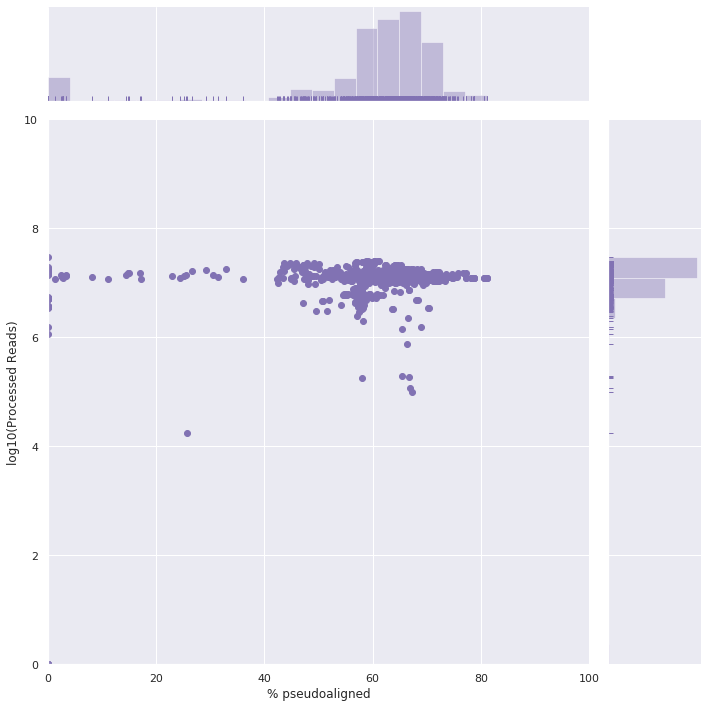

In [22]:
#@markdown 2.5 Scatter plot of log10( number of processed reads ) against % of targets pseudoaligned in each experiment


sns.set(style="darkgrid")

qc_dfa = pd.DataFrame({'% pseudoaligned': p_pseudoaligned, 'log10(Processed Reads)': log10processed})
g = sns.jointplot('% pseudoaligned', 'log10(Processed Reads)', data = qc_dfa, kind="scatter",
                  xlim=(0, 100), ylim=(0, 10), color="m", height=10, marginal_kws=dict(bins=20, rug=True))

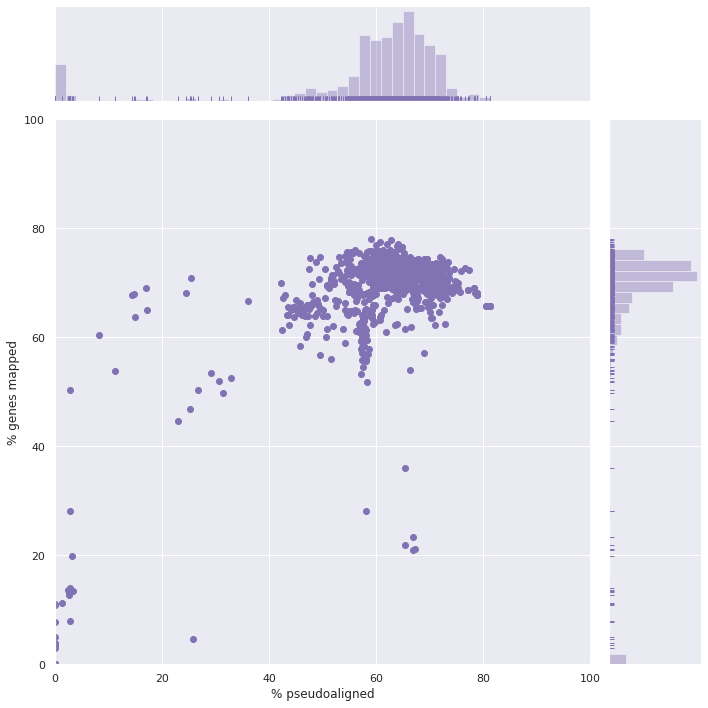

In [23]:
#@markdown 2.6 Scatter plot of % of genes mapped against % of targets pseudoaligned in each experiment

sns.set(style="darkgrid")

qc_dfb = pd.DataFrame({'% pseudoaligned': p_pseudoaligned, '% genes mapped': p_genes_mapped})
g = sns.jointplot('% pseudoaligned', '% genes mapped', data = qc_dfb, kind="scatter",
                  xlim=(0, 100), ylim=(0, 100), color="m", height=10, marginal_kws=dict(bins=40, rug=True))

In [24]:
#@title 2.7 Determine Quality Control Cutoff {display-mode: "form", run: "auto"}
#@markdown Please assess the quality of the downloaded files using the tables and graphs above. By adjusting the sliders below, only RunIDs (experiments) with values above the threshold will be selected for further analysis.

p_pseudoaligned_threshold = 40  #@param {type: "slider", min: 0, max: 100}

#@markdown Enter the log<sub>10</sub> of reads processed instead of absolute number.
reads_processed_threshold = 6 #@param {type: "slider", min: 0, max: 10, step: 0.1}

p_genes_mapped_threshold = 50 #@param {type: "slider", min: 0, max: 100}

#title Collect RunIDs above threshold
accepted_RunIDs = []
ra = qc_df.loc[:,"Reads Pseudoaligned"]
rp = qc_df.loc[:,"Reads Processed"]
gm = qc_df.loc[:,"% genes mapped"]

for i in range(len(ra)):
  if ra[i] >= p_pseudoaligned_threshold and rp[i] >= reads_processed_threshold and gm[i] >= p_genes_mapped_threshold:
    accepted_RunIDs.append(qc_df.loc[i,"RunID"])

print("Number of accepted Run IDs:"+ str(len(accepted_RunIDs)) + "/" + str(len(ra)))

#to_recompile_tpm_values = False #@param {type:"boolean"}

Number of accepted Run IDs:980/1053


###Data Extraction

In [26]:
#@markdown 2.8 Compile TPM values of selected RunIDs
#@markdown <html>2.8.1 Functions to compile TPM values</html>
#Functions#############################################################
def compile_tpm(accepted_RunIDs, tpm_table_file_name):
  #Iterate through the list of selected RunIDs
  for RunID in accepted_RunIDs:
    RunID_file_path = execution_dir_path + RunID + "/"
    if os.path.exists(RunID_file_path) == False:
      print(RunID + ": RunID directory not found.")
    else:
      abun = pd.read_csv(RunID_file_path + "abundance.tsv", sep='\t', header=0, engine="python") #opens abundance.tsv as df
      if RunID == accepted_RunIDs[0]:
        master_tpm = abun[["target_id"]].copy()
      master_tpm.insert(1, RunID, abun["tpm"]) #adds tpm column to collection of tpm values
  master_tpm["target_id"] = master_tpm["target_id"].apply(lambda x: x.lower()) #convert gene IDs to lowercase to match mercator results
  master_tpm.to_csv(working_dir_path + tpm_table_file_name, index=False, sep="\t")
  print("TPM table created at:" + working_dir_path + tpm_table_file_name + ".\n")

######################################################################
#@markdown <html>2.8.2 Compiling TPM values<br></html>
#@markdown <small><strong>Reminder</strong>: This step may take a while to run.</small>
tpm_table_file_name = "compiled_tpm_table_" + abv + ".txt"
# dict_of_genes = compile_tpm(accepted_RunIDs, tpm_table_file_name)
compile_tpm(accepted_RunIDs, tpm_table_file_name)

TPM table created at:/content/gdrive/My Drive/Projects/William_2019/Nta/testnotplant/compiled_tpm_table_Nta.txt.



In [0]:
#@markdown ####2.9 PCC Cutoff & Neighbourhood size {display-mode: "form", run: "auto"}

cutoff = 0.70  #@param {type:"slider", min:0, max:1, step:0.01}
neighbourhood_size = 51 #@param {type: "slider", min:1, max:201, step:1}

#to_recompile_files = False #@param {type:"boolean"}

In [37]:
#@markdown 2.10 Neighbourhood and network files
#@markdown <html>&nbsp&nbsp&nbsp&nbsp2.10.1 Functions to generate neighbourhood and network files</html>
#Functions#############################################################

def extract_mercator(mercator_file_path):
  #Stores gene description
  with open(mercator_file_path, 'r') as mercator_file:
    mercator_file.readline() #header
    mercator_lines = mercator_file.readlines()

  description_dict = {}

  for line in mercator_lines:
    line_list = line.strip().split('\t')
    geneID = line_list[2].strip('\'')
    bin_code = line_list[0].strip('\'')
    bin_name = line_list[1].strip('\'')
    gene_description = line_list[3].strip('\'')
    if geneID != '':
      description_dict[geneID] = [bin_code, bin_name, gene_description]

  return description_dict

######################################################################

def read_tpm_table(tpm_table_file_path):
  #Read TPM Table
  compiled_tpm_table = open(tpm_table_file_path, "r")
  #Read header and store RunIDs, use index of RunID to identify. 
  RunID_list = compiled_tpm_table.readline().strip().split()[1:]

  #Read each row for each gene
  #[genes, ...]
  #[[tpm of gene 1], [tpm of gene 2], ...]
  genes_tpm_rows = compiled_tpm_table.readlines() #list of rows
  genes_list = [line.strip().split('\t')[0] for line in genes_tpm_rows]
  tpm_list_of_lists = [line.strip().split('\t')[1:] for line in genes_tpm_rows]
  compiled_tpm_table.close()

  return RunID_list, genes_list, tpm_list_of_lists

# ######################################################################

# def verify_guide_genes(list_of_guide_genes, genes_list):
#   #Check if guide genes inserted in input section is a GeneID present in genes_list
#   for guide_gene in list_of_guide_genes:
#     if guide_gene not in genes_list:
#       print("The gene " + guide_gene + " is invalid.")
#       list_of_guide_genes.remove(guide_gene)
  
#   return list_of_guide_genes

######################################################################

def make_neighbourhood_file(GoI, neighbourhood_file_path, genes_list, tpm_list_of_list, description_dict):
  #1 Create neightbourhood file output for this guide gene
  neighbourhood_file = open(neighbourhood_file_path, 'w+')
  neighbourhood_file.write('Neighbourhood file for ' + GoI + '\n')
  neighbourhood_file.write('Gene ID\tPCC Value\tp-value\tMapman Bin Code\tMapman Bin Name\tDescription\n')

  GoI_index = genes_list.index(GoI)
  tpm_GoI = [float(tpm) for tpm in tpm_list_of_lists[GoI_index]]

  #Generate a list of list [[gene ID, PCC, p-value], [], ...]
  PCC_output = []

  #Pair GoI with every other gene in genes_list
  for i in range(len(genes_list)):
    tpm_gene2 = [float(tpm) for tpm in tpm_list_of_lists[i]]
    PCC_value, p_value = stats.pearsonr(tpm_GoI, tpm_gene2)
    if PCC_value > cutoff: #Only append pairs with PCC > cutoff
      PCC_output.append([genes_list[i], PCC_value, p_value])

  #Sort by PCC
  PCC_sorted = sorted(PCC_output, key = lambda x: x[1], reverse = True)
  PCC_top = PCC_sorted[:neighbourhood_size] #Write only the top PCC by neighbourhood size

  #Add gene description
  #description_dict = {geneID: [bin_code, gene_name, gene_description]}
  PCC_top_annotated = []
  for result in PCC_top:
    geneID = result[0]
    result.extend(description_dict[geneID]) #extend with [bin_code, bin name, genedesc]
    PCC_top_annotated.append(result) #[gene ID, PCC, p-value, bin_code, bin name, genedesc]

  #write to neighbourhood file
  for result in PCC_top_annotated: 
    result = [str(e) for e in result]
    to_write = '\t'.join(result) + '\n' 
    neighbourhood_file.write(to_write)

  neighbourhood_file.close()

  print(GoI + ": neighbourhood file created at: " + neighbourhood_file_path)

######################################################################

def create_network(GoI, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists):
  #Read neightbourhood file output
  with open(neighbourhood_file_path, 'r') as neighbourhood_file:
    neighbourhood_file.readline() #Title
    neighbourhood_file.readline() #Headers
    neighbourhood_lines = neighbourhood_file.readlines()

  #Collect top genes including GoI itself
  network_genes = [line.strip().split('\t')[0] for line in neighbourhood_lines]

  #Create network file output
  network_file = open(network_file_path, 'w+')
  network_file.write('Network file for ' + GoI + '\n')
  network_file.write('Gene ID 1\tGene ID 2\tPCC Value\tp-value\n')

  #Iterate every gene
  for gene1 in network_genes:
    network_genes_index = network_genes.index(gene1) #for iterating through only genes in neighbourhood file
    genes_list_index1 = genes_list.index(gene1) #find index of gene in genes_list from container extracted by read_tpm_table function
    #Pair gene with every other gene below it in the list
    for i in range((network_genes_index + 1), len(network_genes)): #gene2 is iterated through all the genes below gene1 
      gene2 = network_genes[i]
      tpm_gene1 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index1]]
      genes_list_index2 = genes_list.index(gene2)
      tpm_gene2 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index2]]
      PCC_value, p_value = stats.pearsonr(tpm_gene1, tpm_gene2)

      if math.isnan(PCC_value):
        PCC_value, p_value = 0, 0

      if cutoff <= PCC_value <= 1.0:
        to_write = gene1 + '\t' + gene2 + '\t' + str(PCC_value) + '\t' + str(p_value) + '\n' 
        network_file.write(to_write)

  network_file.close()
  print(GoI + ": network file created at: " + network_file_path)

######################################################################

#@markdown <html>&nbsp&nbsp&nbsp&nbsp2.10.2 Generate neighbourhood and network files</html>
# Extract Mercator Description
description_dict = extract_mercator(merloc)

# Read TPM table 
tpm_table_file_path = execution_dir_path + tpm_table_file_name 
RunID_list, genes_list, tpm_list_of_lists = read_tpm_table(tpm_table_file_path) 

if goi in genes_list:
#for guide_gene in list_of_guide_genes:
  #1 Create neighbourhood file
  neighbourhood_file_path = working_dir_path + 'Neighbourhood_' + goi.replace("|","_") + '.txt'
 # if (not os.path.exists(neighbourhood_file_path)) or to_recompile_files == True:
  make_neighbourhood_file(goi, neighbourhood_file_path, genes_list, tpm_list_of_lists, description_dict)
 # else:
 #   print(goi + ": neighbourhood file already present.")
  
  #2 Create network file
  network_file_path = working_dir_path + 'Network_' + goi.replace("|","_") + '.txt'
  # if (not os.path.exists(network_file_path)) or to_recompile_files == True:
  create_network(goi, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists) #Requires neighbourhood file to be created first
  # else:
  #   print(goi + ": network file already present.")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


lcl|nw_015787229.1_cds_xp_016497259.1_1: neighbourhood file created at: /content/gdrive/My Drive/Projects/William_2019/Nta/testnotplant/Neighbourhood_lcl_nw_015787229.1_cds_xp_016497259.1_1.txt
lcl|nw_015787229.1_cds_xp_016497259.1_1: network file created at: /content/gdrive/My Drive/Projects/William_2019/Nta/testnotplant/Network_lcl_nw_015787229.1_cds_xp_016497259.1_1.txt


##Visualisation of Co-expression Networks

In [77]:
#@markdown 2.11 Generating HTML file for network visualisation
#@markdown <html>&nbsp&nbsp&nbsp&nbsp2.11.1 Functions to generate html file for network visualisation</html>
#Functions#############################################################

def extract_nodes_and_edges(network_file_path):
  '''Opens a network file and return a list of all the edges and nodes within the network'''
  with open(network_file_path, 'r') as network_file:
    network_file.readline() #title
    network_file.readline() #header
    entries = [lines.strip().split('\t') for lines in network_file.readlines()]

  list_of_edges = []
  for i in range(len(entries)):
    if float(entries[i][2]) >= 0.7:
      edge = (entries[i][0], entries[i][1])
      list_of_edges.append(edge)

  list_of_nodes = []
  for j in list_of_edges:
    if j[0] not in list_of_nodes:
      list_of_nodes.append(j[0])
    if j[1] not in list_of_nodes:
      list_of_nodes.append(j[1])
  
  return list_of_nodes, list_of_edges

######################################################################

def style_one_node(GeneID, shape, color):
  '''Returns the string of html css style sheet to be added to the index html file'''
  node_styling='''\
              {
              selector: 'node[id="GENEID"]',
              style: {
                  shape: 'ENTER_SHAPE',
                  'background-color': 'ENTER_COLOR',
                  }
              },
  '''
  node_styling = node_styling.replace('GENEID', GeneID)
  node_styling = node_styling.replace('ENTER_SHAPE', shape)
  node_styling = node_styling.replace('ENTER_COLOR', color)

  return node_styling

######################################################################

def read_neighbourhood_file(neighbourhood_file_path):
  with open(neighbourhood_file_path, "r") as neighbourhood_file:
    neighbourhood_file.readline() #title
    neighbourhood_file.readline() #header
    lines_list = [line.strip().split("\t") for line in neighbourhood_file.readlines()]

  # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}
  gene_info_dict = {}
  for line in lines_list:
    gene_info_dict[line[0]] = [line[3], line[4], line[5]]
  
  return gene_info_dict

######################################################################

def read_color_table(MapmanBin_color_table_path):
  '''Returns color_dict = {Bin number: [Bin name, shape, color]}'''
  with open(MapmanBin_color_table_path, "r") as color_table:
    color_table.readline() #header
    lines = [line.strip().split("\t") for line in color_table.readlines()]
  
  color_dict = {}
  for line in lines:
    color_dict[int(line[0])] = [line[1], line[2], line[3]]
  
  return color_dict

######################################################################

def generate_html_index(list_of_nodes, list_of_edges):
  '''Returns a string of a html with javascript code to render the network from list_of_nodes and list_of_edges'''
  front_html = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 1000px;
            height: 950px;
            }
    </style>

    <body style="background-color:rgb(194, 229, 243);">
      <div><p>Click to download as: <br><a id="pngimage" href="#" download="NetworkImage.png">Image</a> | <a id="cyjson" href="#" download="NetworkImage.json">JSON</a></p></div>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
  '''


  mid_html = '''\
          elements: {
              nodes: [\n
  '''

  #Read neighbourhood files
  neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + goi.replace("|","_") + '.txt'
  gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) #Need to include arabidopsis orthologs too! (run diamond?)

  #Read Mapman Bin to Color table
  MapmanBin_color_table_path = "/content/MapmanBin_colorsc.txt"
  color_dict = read_color_table(MapmanBin_color_table_path)

  #get nodes
  # { data: { id: 'a', node_type: 'q/t', color: 'x', shape: 'z' } },
  if is_a_plant == True:
    for j in list_of_nodes:
      bin_code = int(gene_info_dict[j][0].split(".")[0])
      shape, color = color_dict[bin_code][1], color_dict[bin_code][2]
      ntype = "linked"
      if j == list_of_nodes[0]:
        ntype = "query"
        color = "gold"
        shape = "vee"
      new_node = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
        "\t"*6 + "id: \'" + j + "\',\n" +\
        "\t"*6 + "node_type: \'" + ntype + "\',\n" +\
        "\t"*6 + "color: \'" + color + "\',\n" +\
        "\t"*6 + "shape: \'" + shape + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
      if list_of_nodes.index(j) != len(list_of_nodes)-1:
        new_node += ",\n"
      else:
        new_node += "\n\t\t\t\t],\n"
      mid_html += new_node
  else:
    for j in list_of_nodes:
      shape, color = "triangle", "Silver"
      ntype = "linked"
      if j == list_of_nodes[0]:
        ntype = "query"
        color = "Gold"
        shape = "vee"
      new_node = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
        "\t"*6 + "id: \'" + j + "\',\n" +\
        "\t"*6 + "node_type: \'" + ntype + "\',\n" +\
        "\t"*6 + "color: \'" + color + "\',\n" +\
        "\t"*6 + "shape: \'" + shape + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
      if list_of_nodes.index(j) != len(list_of_nodes)-1:
        new_node += ",\n"
      else:
        new_node += "\n\t\t\t\t],\n"
      mid_html += new_node

  mid2_html = '''\
              edges: [\n
  '''
  mid_html += mid2_html
  #get edges
  for i in range(len(list_of_edges)):
    ID = list_of_edges[i][0] + " | " + list_of_edges[i][1]
    source = list_of_edges[i][0]
    target = list_of_edges[i][1]
    new_edge = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
      "\t"*7 + "id: \'" + ID + "\',\n" +\
      "\t"*7 + "source: \'" + source + "\',\n" +\
      "\t"*7 + "target: \'" + target + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
    if i != (len(list_of_edges)-1):
      new_edge += ",\n"
    else:
      new_edge = new_edge + "\n\t\t\t\t]\n"
    mid_html += new_edge

  back_html = '''\
            },
            style: [
              { 
              selector: "node",
              style: {
                  shape: 'data(shape)',
                  'height': '3px',
                  'width': '3px',
                  'background-color': 'data(color)',
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 1.2,
                  'text-margin-y':'-0.4px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              },
            ],
            layout: {
              name: 'cose',
              animateThreshold: 1,
              nodeOverlap: 100,
              gravity: 400,
              componentSpacing: 100,
              edgeElasticity: 100,
              minTemp: 1,
              initialTemp: 1000,
              stop: function() {
                  //generate PNG image to display from "id = pngimage"
                  var png64 = cy.png({bg:'white'});
                  document.getElementById('pngimage').setAttribute('href', png64);
                  //generate JSON to download for id = cyjson
                  var jsonc = JSON.stringify(cy.json(), null, "\\t");
                  document.getElementById('cyjson').setAttribute('href', 'data:text/plain;charset=utf-8,' + encodeURIComponent(jsonc));
              }
            }
        });

      </script>
    </body>
  </html>
  '''

  index_html = front_html + mid_html + back_html
  return index_html

######################################################################

def save_index_file(index_html, guide_gene):
  '''Writes the html/js string into a html file and return the path to the new html file'''
  network_html_path = working_dir_path + "Network_index_" + guide_gene + '.html'
  with open(network_html_path, 'w+') as index_file:
    index_file.write(index_html)
  print("HTML file saved in: " + network_html_path+ "\n")
  return network_html_path

######################################################################

#@markdown <html>&nbsp&nbsp&nbsp&nbsp2.11.2 Create html files for network visualisation. <strong>Please uncheck if your organism is not a plant.</strong><br></html>
is_a_plant = False #@param {type: "boolean"}

#Read network file for nodes and edges
list_of_nodes, list_of_edges = extract_nodes_and_edges(execution_dir_path + "Network_" + goi.replace("|","_") + ".txt")
index_html = generate_html_index(list_of_nodes, list_of_edges) #string
index_html = index_html.replace('NetworkImage', goi.replace("|","_")) #Specify Name of png file to be downloaded based on guide gene

# Save string into final html file
network_html_path = save_index_file(index_html, goi.replace("|","_"))
#list_of_network_html_path.append(network_html_path)

HTML file saved in: /content/gdrive/My Drive/Projects/William_2019/Nta/testnotplant/Network_index_lcl_nw_015787229.1_cds_xp_016497259.1_1.html



In [82]:
#@markdown 2.12 Display Network
#network_html_path = list_of_network_html_path[0]
IPython.display.HTML(filename = network_html_path)

In [81]:
#@markdown 2.13 Legend for nodes based on Mapman Bins:

nodes_elements = ""

if is_a_plant == True:
  #color_dict = {Bin number: [Bin name, shape, color]}
  MapmanBin_color_table_path = "/content/MapmanBin_colorsc.txt"
  color_dict = read_color_table(MapmanBin_color_table_path)

  for key in color_dict:
    bin_name, shape, color = color_dict[key][0], color_dict[key][1], color_dict[key][2]
    #Add node to elements
    # { data: { id: 'a', color: 'x', shape: 'z' } },
    new_node = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
        "\t"*6 + "id: \'" + bin_name + "\',\n" +\
        "\t"*6 + "color: \'" + color + "\',\n" +\
        "\t"*6 + "shape: \'" + shape + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "},\n"
    nodes_elements += new_node
else:
  color_dict = {'query': ['Guide gene', 'Gold', 'vee'], 'others': ['Other genes', 'Silver', 'triangle']}
  for key in color_dict:
    bin_name, color, shape = color_dict[key][0], color_dict[key][1], color_dict[key][2]
    #Add node to elements
    # { data: { id: 'a', color: 'x', shape: 'z' } },
    new_node = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
        "\t"*6 + "id: \'" + bin_name + "\',\n" +\
        "\t"*6 + "color: \'" + color + "\',\n" +\
        "\t"*6 + "shape: \'" + shape + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "},\n"
    nodes_elements += new_node

legend_html_head = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 900px;
            height: 950px;
            }
    </style>
    
    <body>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
            elements: [
				          // nodes
'''

legend_html_mid ='''
			      ],
            style: [
              {
              // Set the default node styling first
              selector: 'node',
              style: {
                  shape: 'data(shape)',
                  'height': '20px',
                  'width': '20px',
                  'background-color': 'data(color)',
                  'background-opacity':1,
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 12,
                  'text-margin-y':'-20px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              }
              ],
            layout: {
              name: 'grid'              
            }            
          });
          cy.zoomingEnabled(false);          
      </script>
    </body>
  </html>
'''

if is_a_plant == True:
  legend_html = legend_html_head + nodes_elements[:-2] + "\n" + legend_html_mid
else:
  legend_html = legend_html_head.replace("height: 950px","height: 200px").replace("width: 900px", "width: 800px")\
  + nodes_elements[:-2] + "\n" + legend_html_mid
display(HTML(legend_html))

In [42]:
#@markdown 2.14 Details of Genes in Network
#neighbourhood_file_path = neighbourhood_files[0]
df = pd.read_table(neighbourhood_file_path, sep="\t", header=1)
pd.set_option('display.max_colwidth', -1)
new_df = df[["Gene ID", "PCC Value", "Mapman Bin Code", "Mapman Bin Name", "Description"]]
new_df.style.set_properties(**{'text-align': 'left'})
new_df.style.set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])

,Gene ID,PCC Value,Mapman Bin Code,Mapman Bin Name,Description
0,lcl|nw_015787229.1_cds_xp_016497259.1_1,1,nan,nan,"class I ARF-GAP ARF-GTPase-activating protein (original description: [gene=LOC107813361] [db_xref=GeneID:107813361] [protein=ADP-ribosylation factor GTPase-activating protein AGD2-like] [protein_id=XP_016497259.1] [location=join(21..168,253..392,556..610,2767..2886,2974..3030,4652..4941,5490..5573,5649..5921,8423..8544,8893..8980,10502..10947,12214..12328)] [gbkey=CDS])"
1,lcl|nw_015899831.1_cds_xp_016449857.1_44363,0.823564,nan,nan,"protease (SBT6.1) (original description: [gene=LOC107774733] [db_xref=GeneID:107774733] [protein=subtilisin-like protease SBT6.1] [partial=5'] [protein_id=XP_016449857.1] [location=complement(join(32538..32620,32710..32770,33033..33524,34109..35177,35258..35521,36014..36198,37174..37300,38519..>38613))] [gbkey=CDS])"
2,lcl|nw_015887819.1_cds_xp_016442297.1_37572,0.803507,nan,nan,"(original description: [gene=LOC107767726] [db_xref=GeneID:107767726] [protein=protein transport protein SEC24-like] [protein_id=XP_016442297.1] [location=complement(join(9490..9701,9799..10013,11283..11560,15280..15403,16469..16567,17077..17192,17278..17359,18512..18666,18744..18889,19132..19318,19440..19612,19703..19756,20650..20709,20821..21148))] [gbkey=CDS]) & Protein transport protein Sec24-like At3g07100 OS=Arabidopsis thaliana (sp|q9sfu0|sc24a_arath : 107.0)"
3,lcl|nw_015826145.1_cds_xp_016502566.1_16195,0.791552,nan,nan,"(original description: [gene=LOC107820741] [db_xref=GeneID:107820741] [protein=phosphatidylinositol 4-kinase alpha 1] [protein_id=XP_016502566.1] [location=complement(join(42479..42680,42805..42977,43534..43578,43714..43791,44200..44466,47362..47512,47604..47737,47908..48088,52376..52590,53430..53789,53912..54406,54874..55056,55156..55314,56373..56590,56744..56912,60700..61006,61084..61211,61301..61459,61601..61771,67104..67259,67354..67695,67980..68819))] [gbkey=CDS]) & Phosphatidylinositol 4-kinase alpha 1 OS=Arabidopsis thaliana (sp|q9sxa1|p4ka1_arath : 2081.0)"
4,lcl|nw_015914710.1_cds_xp_016464667.1_57687,0.789817,nan,nan,"ATG7 autophagosome ATG8/12-activating E1 protein (original description: [gene=LOC107787591] [db_xref=GeneID:107787591] [protein=ubiquitin-like modifier-activating enzyme atg7] [protein_id=XP_016464667.1] [location=join(3470..3605,4205..4422,4675..4866,4948..5002,5106..5200,5365..5554,5652..5757,5832..5976,6067..6225,6326..6514,6641..6841,6926..7041,7128..7287,7476..7655)] [gbkey=CDS])"
5,lcl|nw_015938284.1_cds_xp_016483241.1_74377,0.789364,nan,nan,"subunit alpha of RAB-GTPase geranylgeranyltransferase (RGT) complex (original description: [gene=LOC107803956] [db_xref=GeneID:107803956] [protein=uncharacterized protein LOC107803956] [protein_id=XP_016483241.1] [location=join(28162..28277,28377..28545,29232..29392,29476..29580,30851..31651,31745..31934,32596..32779,35170..35564)] [gbkey=CDS])"
6,lcl|nw_015938284.1_cds_xp_016483242.1_74378,0.789364,nan,nan,"subunit alpha of RAB-GTPase geranylgeranyltransferase (RGT) complex (original description: [gene=LOC107803956] [db_xref=GeneID:107803956] [protein=uncharacterized protein LOC107803956] [protein_id=XP_016483242.1] [location=join(28162..28277,28377..28545,29232..29392,29476..29580,30851..31651,31745..31934,32596..32779,35170..35564)] [gbkey=CDS])"
7,lcl|nw_015938284.1_cds_xp_016483243.1_74379,0.789364,nan,nan,"subunit alpha of RAB-GTPase geranylgeranyltransferase (RGT) complex (original description: [gene=LOC107803956] [db_xref=GeneID:107803956] [protein=uncharacterized protein LOC107803956] [protein_id=XP_016483243.1] [location=join(28162..28277,28377..28545,29232..29392,29476..29580,30851..31651,31745..31934,32596..32779,35170..35564)] [gbkey=CDS])"
8,lcl|nw_015910898.1_cds_xp_016460963.1_54334,0.788128,nan,nan,"(original description: [gene=LOC107784349] [db_xref=GeneID:107784349] [protein=uncharacterized protein LOC107784349] [protein_id=XP_016460963.1] [location=complement(join(53677..54045,54404..56677,56772

\- End of Script -